# TSP: Traveling Salesman Problem
## El problema del vendedor viajero
- Sea $C$ el conjunto de ciudades que se deben visitar, con $C=\{0,...,n-1\}$.
- Sea $E$ el conjunto de arcos o links que unen a las ciudades, con $E=\{(i,j)\in C^2 : i\neq j\}$.
- Sea $x_{(i,j)}$ una variable binaria que es igual a 1 cuando se viaja de forma directa desde la ciudad $i$ a la ciudad $j$, con $(i,j)\in E$, y es igual cero en caso contrario.
- Sea $d_e$ la distancia del arco $e\in E$.

Luego, el problema a optimizar es el siguiente:
\begin{align}
\max \quad & \sum_{e\in E} d_e x_e \\
\text{s.t.} \quad & \sum_{e=(i,j)\in E} x_e = 1  &&\forall i \in C \\
 & \sum_{e=(i,j)\in E} x_e = 1 && \forall j \in C  \\
 & u_i + 1 \leq u_j + M(1-x_{ij})&& \forall (i,j)\in E : j\neq 0 \\
 & x_e \in \{0,1\} && \forall (i,j)\in E\\
 & u_i \geq 0 && \forall i \in C
\end{align}

In [1]:
import numpy as np
from docplex.mp.model import Model
import docplex.mp.solution as mp_sol

In [2]:
n = 5
ciudades = [i for i in range(n)]

In [3]:
arcos = [(i,j) for i in ciudades for j in ciudades if i != j]

In [4]:
rnd = np.random
rnd.seed(1)
coord_x = rnd.rand(n)*100
coord_y = rnd.rand(n)*100
distancia = {(i,j):np.hypot(coord_x[i]-coord_x[j],coord_y[i]-coord_y[j])
            for i,j in arcos}

In [5]:
mdl = Model('TSP')

In [6]:
x = mdl.binary_var_dict(arcos,name='x')
u = mdl.continuous_var_dict(ciudades,name='u')

In [7]:
u

{0: docplex.mp.linear.Var(type=C,name='u_0'),
 1: docplex.mp.linear.Var(type=C,name='u_1'),
 2: docplex.mp.linear.Var(type=C,name='u_2'),
 3: docplex.mp.linear.Var(type=C,name='u_3'),
 4: docplex.mp.linear.Var(type=C,name='u_4')}

$$\min \sum_{e\in E} d_e x_e$$

In [8]:
mdl.minimize(mdl.sum(distancia[e]*x[e] for e in arcos))

$$\sum_{e=(i,j)\in E} x_e = 1 \quad \forall i \in C$$

In [9]:
for c in ciudades:
    mdl.add_constraint(mdl.sum(x[(i,j)] for i,j in arcos if i==c)==1,
                      ctname='out_%d'%c)

$$\sum_{e=(i,j)\in E} x_e = 1 \quad \forall j \in C $$

In [10]:
for c in ciudades:
    mdl.add_constraint(mdl.sum(x[(i,j)] for i,j in arcos if j==c)==1,
                      ctname='in_%d'%c)

$$u_i + 1 \leq u_j + M(1-x_{ij}) \quad \forall (i,j)\in E : j\neq 0$$

In [11]:
M = 1000
for i, j in arcos:
    if j!=0:
        mdl.add_constraint(u[i] + 1 <= u[j] + M*(1-x[(i,j)]))

In [12]:
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: 31.751168441815 x_(0,_1) + 48.778419421916 x_(0,_2)
      + 32.531616695012 x_(0,_3) + 52.190660192136 x_(0,_4)
      + 31.751168441815 x_(1,_0) + 73.761729186674 x_(1,_2)
      + 46.800700163199 x_(1,_3) + 67.325852654323 x_(1,_4)
      + 48.778419421916 x_(2,_0) + 73.761729186674 x_(2,_1)
      + 30.652564337715 x_(2,_3) + 24.259352514227 x_(2,_4)
      + 32.531616695012 x_(3,_0) + 46.800700163199 x_(3,_1)
      + 30.652564337715 x_(3,_2) + 21.067058676153 x_(3,_4)
      + 52.190660192136 x_(4,_0) + 67.325852654323 x_(4,_1)
      + 24.259352514227 x_(4,_2) + 21.067058676153 x_(4,_3)
Subject To
 out_0: x_(0,_1) + x_(0,_2) + x_(0,_3) + x_(0,_4) = 1
 out_1: x_(1,_0) + x_(1,_2) + x_(1,_3) + x_(1,_4) = 1
 out_2: x_(2,_0) + x_(2,_1) + x_(2,_3) + x_(2,_4) = 1
 out_3: x_(3,_0) + x_(3,_1) + x_(3,_2) + x_(3,_4) = 1
 out_4: x_(4,_0) + x_(4,_1) + x_(4,_2) + x_(4,_3) = 1
 in_0: x_(1,_0) + x_(2,_0) +

In [13]:
tour = [0]
while len(tour) < n:
    k = tour[-1]
    new_dist = {(i,j):d for d, (i,j) in enumerate(distancia) 
                if i==k and j not in tour}
    (i, j) = min(new_dist, key=new_dist.get)
    tour.append(j)
tour

[0, 1, 2, 3, 4]

In [14]:
sol_inicial = mp_sol.SolveSolution(mdl)
for g in range(n):
    i = tour[g - 1]
    j = tour[g]
    sol_inicial.add_var_value(x[(i,j)], 1)
print(sol_inicial)

solution for: TSP
x_(4, 0)=1
x_(0, 1)=1
x_(2, 3)=1
x_(1, 2)=1
x_(3, 4)=1



In [15]:
mdl.add_mip_start(sol_inicial)
mdl.parameters.timelimit = 60
mdl.parameters.mip.tolerances.mipgap = 0.2
mdl.parameters.mip.strategy.branch = 1
solucion = mdl.solve(log_output=True)

CPXPARAM_TimeLimit                               60
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strategy_Branch                     1
CPXPARAM_MIP_Tolerances_MIPGap                   0.20000000000000001
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 209.4232.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 1 columns.
MIP Presolve modified 8 coefficients.
Reduced MIP has 26 rows, 24 columns, and 84 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Cover probing fixed 0 vars, tightened 4 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 4 rows and 0 columns.
Reduced MIP has 22 rows, 24 columns, and 76 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.0

In [16]:
mdl.get_solve_status()

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [17]:
solucion.display()

solution for: TSP
objective: 172.657
x_(0, 2) = 1
x_(4, 3) = 1
x_(1, 0) = 1
u_1 = 4.000
u_2 = 1.000
u_3 = 3.000
u_4 = 2.000
x_(2, 4) = 1
x_(3, 1) = 1


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

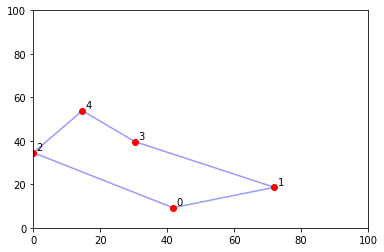

In [19]:
arcos_activos = [e for e in arcos if x[e].solution_value > 0.9]
for i,j in arcos_activos:
    plt.plot([coord_x[i],coord_x[j]],[coord_y[i],coord_y[j]],
              color='b', alpha=0.4, zorder=0)
plt.scatter(x=coord_x, y=coord_y, color='r', zorder=1)
for i in ciudades:
    plt.annotate(i,(coord_x[i]+1,coord_y[i]+1))
plt.xlim((0,100))
plt.ylim((0,100))
plt.show()